# **1. Basics**
**Prerequisites**

`pytorch`, `torchvision`, `numpy`, `openCV2`,`matplotlib`

In [1]:
# For plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# For utilities
import time, sys, os

# For conversion
import cv2
import opencv_transforms.transforms as TF
import dataloader

# For everything
import torch
import torch.nn as nn
import torchvision.utils as vutils

# For our model
import mymodels
import torchvision.models

# To ignore warning
import warnings
warnings.simplefilter("ignore", UserWarning)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device=='cuda':
    print("The gpu to be used : {}".format(torch.cuda.get_device_name(0)))
else:
    print("No gpu detected")

The gpu to be used : GeForce RTX 3060 Ti


# **2. Loading dataset**

## 2.1 Color to sketch converter

The `netC2S` is a network that convert a colorful image to sketch image. The network was pretrained on the dataset [1]. Even though there are some other methods to convert image to sketch like edge detection, Just forwding another pretrained network gives better result.

To load the model weights, download the checkpoint on https://drive.google.com/open?id=1pIZCjubtyOUr7AXtGQMvzcbKczJ9CtQG (449MB) and unzip on directory `./checkpoint`. 
Then the file on `./checkpoint/color2edge/ckpt.pth` will be loaded.

[1] Taebum Kim, "Anime Sketch Colorization Pair", https://www.kaggle.com/ktaebum/anime-sketch-colorization-pair, 2019., 2020.1.13.

In [3]:
with torch.no_grad():
    netC2S = mymodels.Color2Sketch(pretrained=True).to(device)
    netC2S.eval()

Loading pretrained Color2Sketch model... Done!


## 2.2 Load data

To pre-process input images, the module `opencv_transforms.transforms` and `opencv_transforms.functional` are used. These are implemented with **openCV** so much faster than `torchvision.transforms` which is based on **Pillow**.[2] You can download the module on [2].

To download validation dataset, go [1] and download. Unzip the images on directory `./dataset/val/`.

I've alreay set some validation and test images. If you want test on orther images, put the image on `./dataset/test/`. 

[2] Jim Bohnslav,"opencv_transforms", https://github.com/jbohnslav/opencv_transforms, 2020.1.13.

In [33]:
# batch_size. number of cluster
batch_size = 1
ncluster = 9

# Validation 
print('Loading Validation data...', end=' ')
val_transforms = TF.Compose([
    TF.Resize(512),
    ])
val_imagefolder = dataloader.PairImageFolder('./dataset/val', val_transforms, netC2S, ncluster)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=batch_size, shuffle=False)
print("Done!")
print("Validation data size : {}".format(len(val_imagefolder)))


# Test
print('Loading Test data...', end=' ')
test_transforms = TF.Compose([
    TF.Resize(512),
    ])
test_imagefolder = dataloader.GetImageFolder('./dataset/test', test_transforms, netC2S, ncluster)
test_loader = torch.utils.data.DataLoader(test_imagefolder, batch_size=batch_size, shuffle=False)
print("Done!")
print("Test data size : {}".format(len(test_imagefolder)))

# Reference
print('Loading Reference data...', end=' ')
refer_transforms = TF.Compose([
    TF.Resize(512),
    ])
refer_imagefolder = dataloader.GetImageFolder('./dataset/reference', refer_transforms, netC2S, ncluster)
refer_loader = torch.utils.data.DataLoader(refer_imagefolder, batch_size=1, shuffle=False)
refer_batch = next(iter(refer_loader))
print("Done!")
print("Reference data size : {}".format(len(refer_imagefolder)))

Loading Validation data... Done!
Validation data size : 1
Loading Test data... Done!
Test data size : 1
Loading Reference data... Done!
Reference data size : 1


## 2.3 Dataset Test

Check the dataset

In [34]:
temp_batch_iter = iter(refer_loader)

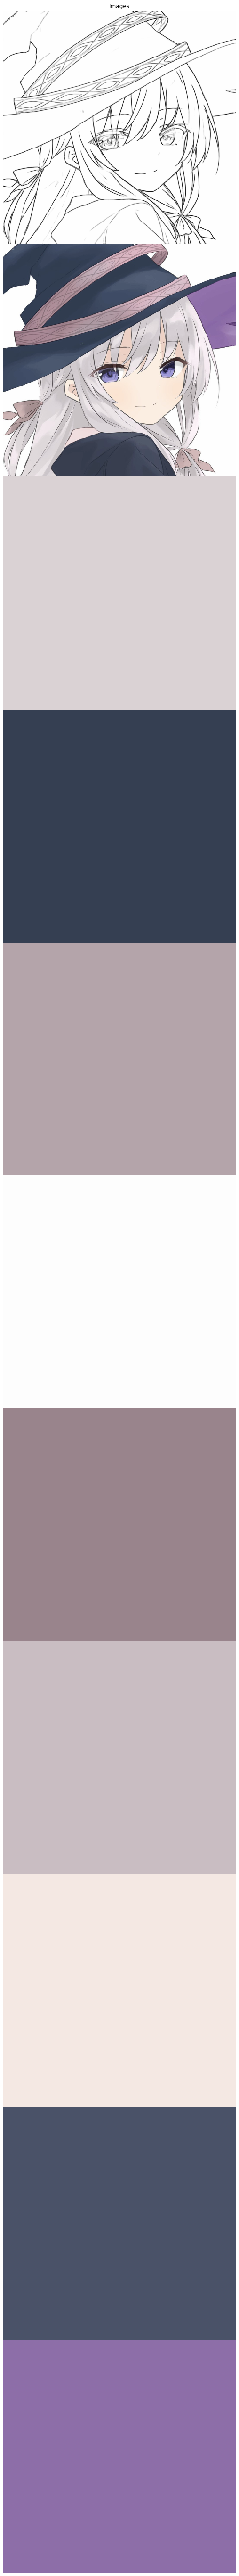

In [35]:
temp_batch = next(temp_batch_iter)
edge = temp_batch[0]
color = temp_batch[1]
color_palette = temp_batch[2]

plt.figure(figsize=(16, 100))
result =torch.cat([edge, color]+color_palette,dim=-2)
plt.imshow(np.transpose(vutils.make_grid(result, nrow=6, padding=5, normalize=True).cpu(),(1,2,0)))
plt.axis("off")
plt.title("Images")
plt.show()

# **3. Load the Model**

The model are implemented on `mymodels.py`.

To load the model weights, download the checkpoint on https://drive.google.com/open?id=1pIZCjubtyOUr7AXtGQMvzcbKczJ9CtQG (449MB) and unzip on directory `./checkpoint`. 
Then the file on `./checkpoint/edge2color/ckpt.pth` will be loaded.


In [14]:
# A : Edge, B : Color
nc = 3 * (ncluster + 1)
netG = mymodels.Sketch2Color(nc=nc, pretrained=True).to(device) 

num_params = sum(p.numel() for p in netG.parameters() if p.requires_grad)
print('Number of parameters: %d' % (num_params))

torch.backends.cudnn.benchmark = True

Loading pretrained Sketch2Color model... Done!
Number of parameters: 63504297


# **4. Results**

## 4.1 Show colorization results

Show colorization results on val/test batch

In [39]:
temp_batch_iter=iter(test_loader)

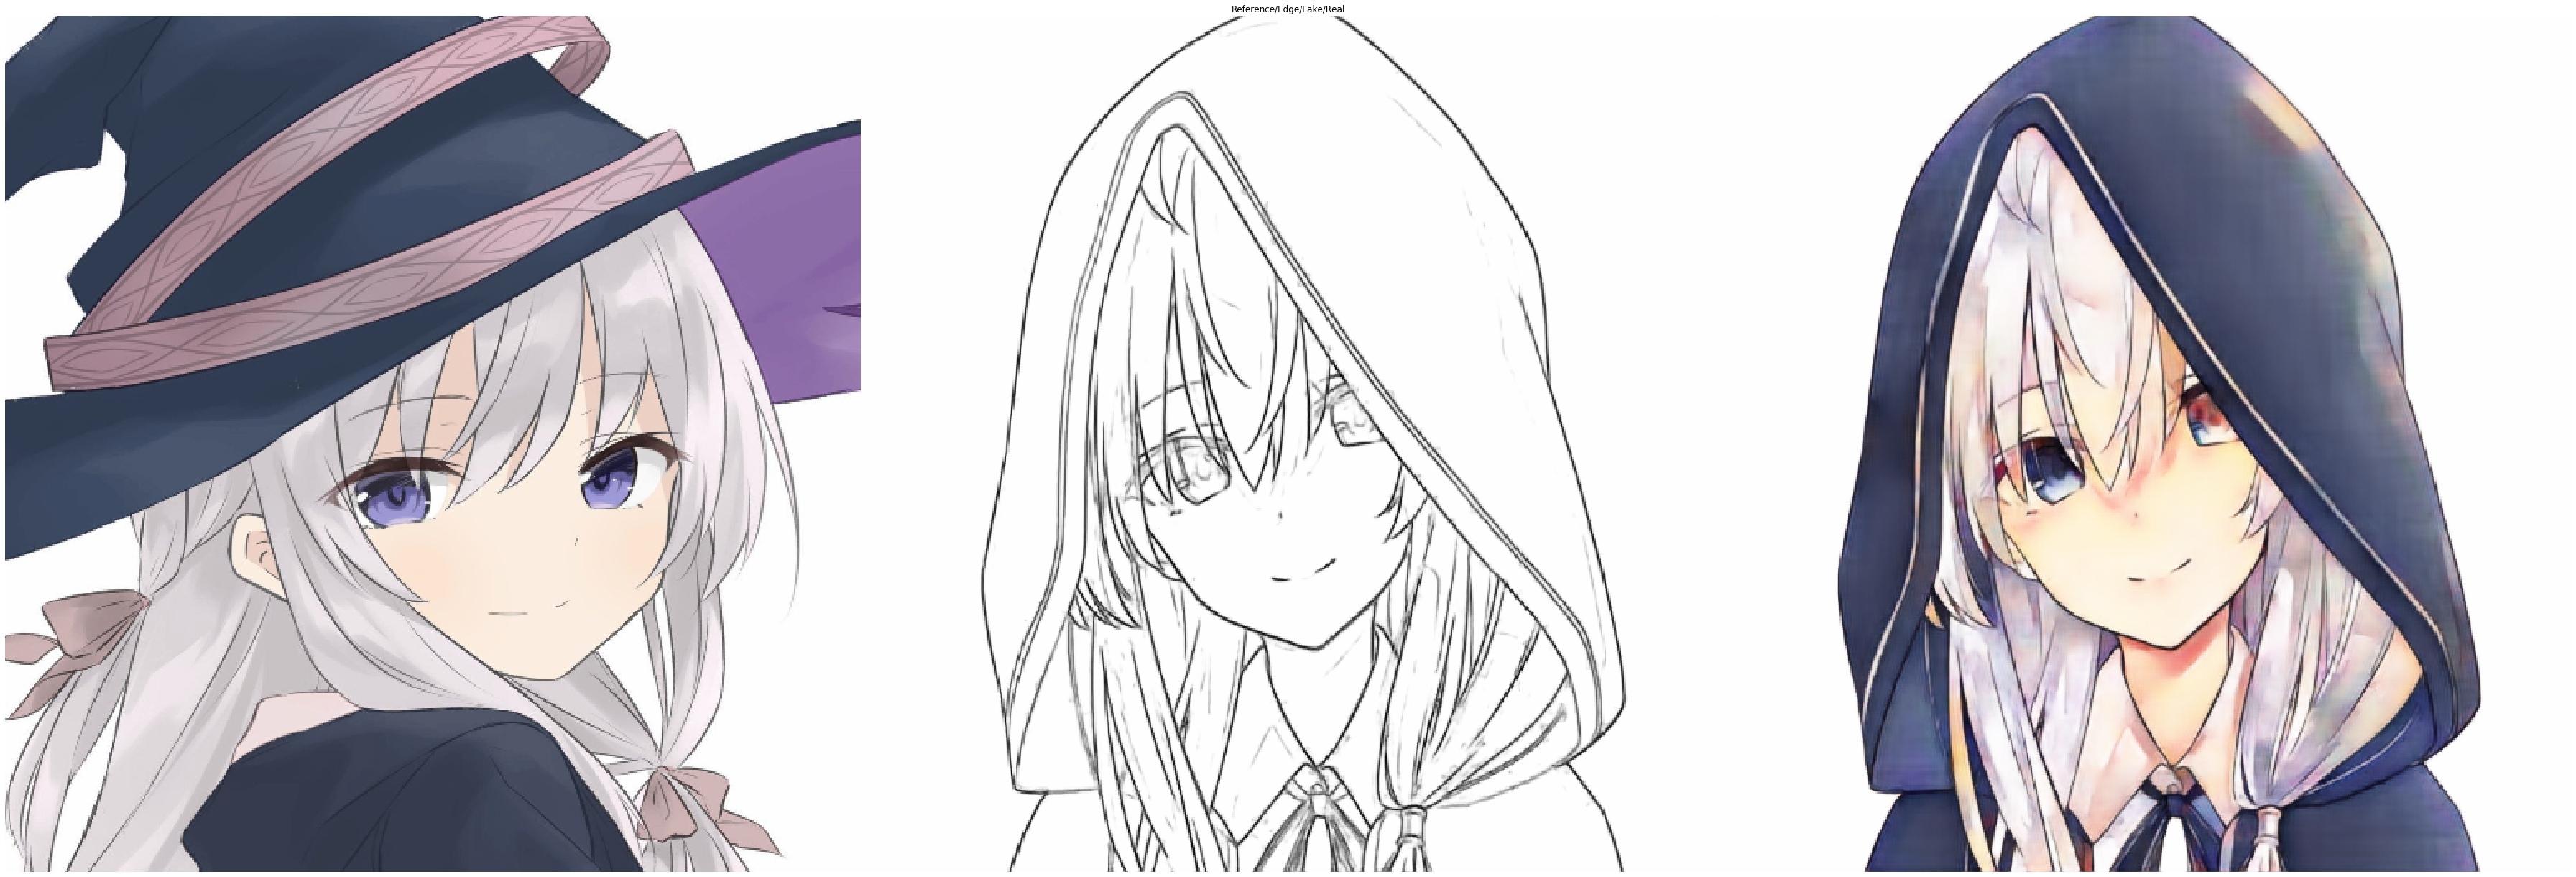

In [40]:
netG.eval()
temp_batch = next(temp_batch_iter)

with torch.no_grad():
    
    edge = temp_batch[0].to(device)
    real = temp_batch[1].to(device)
    reference = refer_batch[1].to(device)
    color_palette = refer_batch[2]
    input_tensor = torch.cat([edge.cpu()]+color_palette, dim=1).to(device)
    fake = netG(input_tensor)
    result = torch.cat((reference, edge, fake), dim=-1).cpu()
    
    plt.figure(figsize=(64,64))    
    plt.imshow(vutils.make_grid(result, nrow=1, padding=5, normalize=True).cpu().permute(1,2,0))    
    plt.axis("off")
    plt.title("Reference/Edge/Fake/Real")

## 4.2 Save colorization results

Save colorization results on val/test batch on `./outputs/sketch2color` directory.

The saved images have form of **Reference/Edge/Colorization Result/Ground Truth**

In [9]:
# validation funciton
def save_images(data_loader, model):
    with torch.no_grad():
        # Prepare value counters and timers
        for i, data in enumerate(data_loader, 0):
            # Record time to do forward passes and save images
            start = time.time()
            
            edge = data[0].to(device)
            edge = torch.cat([edge]*6, dim=0)
            real = data[1].to(device)
            real = torch.cat([real]*6, dim=0)
            reference = refer_batch[1].to(device)
            color_palette = refer_batch[2]
            input_tensor = torch.cat([edge.cpu()]+color_palette, dim=1).to(device)
            fake = netG(input_tensor)
            result = torch.cat((reference, edge, fake, real), dim=-1)
            output = vutils.make_grid(result, nrow=1, padding=5, normalize=True).cpu().permute(1,2,0).numpy()
            
            # Save images to file
            save_path = 'outputs/sketch2color/'
            save_name = 'img-{}.jpg'.format(i)
            plt.imsave(arr=output, fname='{}{}'.format(save_path, save_name))

            # Record time to do forward passes and save images
            end = time.time()

            # Print model accuracy -- in the code below, val refers to both value and validation
            print('\rSave: [{0}/{1}]\t'
                'Time {2:0.3f}s \t'
                .format(i+1, len(data_loader), end - start), end='')

In [10]:
with torch.no_grad():
    netG.eval()
    save_images(val_loader, netG)

Save: [21/21]	Time 0.975s 	